# Reading the ROOT files

In [2]:
import networkx as nx

In [3]:
import torch
from tqdm import tqdm

In [146]:
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GCNConv, ASAPooling
from torch.nn import Linear, Sequential, ReLU, Dropout, Sigmoid

In [5]:

def get_paired_data(data):
    next_ts = data.timestamp[1:]
    next_ts = ak.concatenate([next_ts, 0])

    condition_1 = next_ts - data.timestamp<600
    condition_2 = next_ts - data.timestamp>0
    condition_3 = data.dt_next_us < 600

    both = condition_1 * condition_2 * condition_3

    first_of_two = ak.where(both)[0]
    signal1 = data[first_of_two]
    signal2 = data[first_of_two+1]
    
    return signal1, signal2
ibd = ak.from_json('data/ibd.json')
fastn = ak.from_json('data/fastn_water.json')

fn0, fn1 = get_paired_data(fastn)
ibd0, ibd1 = get_paired_data(ibd)

NameError: name 'ak' is not defined

In [7]:
selection = [ibd0, fn0]
samples = min([len(i) for i in selection])
first_signal = ak.concatenate([fn0[:samples], ibd0[:samples]])
second_signal = ak.concatenate([fn1[:samples], ibd1[:samples]])
y = np.where(first_signal.code==2, 0, 1)
trainidx, testidx = train_test_split(np.arange(len(y)), test_size=.25, random_state=43)
train = dict(ev1 = first_signal[trainidx],
             ev2 = second_signal[trainidx],
             y = y[trainidx]
            )
test = dict(ev1 = first_signal[testidx],
             ev2 = second_signal[testidx],
             y = y[testidx]
            )

# pickle.dump(test, open( "./data/test_water_og.pkl", "wb" ))

In [62]:
fastn = uproot.open('data/fastn_water.root'+':data')
fastn= fastn.arrays(library='awkward')

# Time-sort all the data arrays for recurrent/sequential purposes. 
for j, data in enumerate([fastn]):
    print('set %i'%(j))
    args = ak.argsort(data['hittime'])
    for key in ['hittime', 'pmtcharge', 'channel']:
        data[key] = data[key][args]
        
# Get rid of the first and last events of each run 
fastn = fastn[fastn['inner_hit_prev']>0]
fastn = fastn[fastn['inner_hit_next']>0]
fastn = fastn[fastn['dt_prev_us']>0]
ak.to_json(fastn, 'data/fastn_water.json')

In [32]:
# exec(open("./do_imports.py").read())

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

In [6]:
from evaluate_results import *
from batched_data import *
import cnn_batched_data

In [7]:
import uproot
import numpy as np
import pandas as pd

In [15]:
ibdp = uproot.open('data/ibd_p.root'+':data')
ibdn = uproot.open('data/ibd_n.root'+':data')
ibdp = ibdp.arrays(library='awkward')
ibdn = ibdn.arrays(library='awkward')

In [22]:
for j, data in enumerate([ibdp, ibdn]):
    print('set %i of %i'%(j+1, 3))
    args = ak.argsort(data['hittime'])
    for key in ['hittime', 'pmtcharge', 'channel']:
        data[key] = data[key][args]

set 1 of 3
set 2 of 3


In [29]:
samples = min([len(ibdp), len(ibdn)])
alldata = ak.concatenate([ibdp[:samples], ibdn[:samples]])
y = np.append(np.zeros(samples), np.ones(samples))
indexes = np.arange(len(alldata))

In [72]:
def get_input_gcn(data, batch_size=16):
    dat = data[0]
    y = data[1]
    charge = np.zeros((batch_size, 2330))
    for i in range(batch_size):
        charge[i, dat.channel[i]]= charge[i, dat.channel[i]] + dat.pmtcharge[i]
    charge = np.reshape( charge, (len( charge ), 2330,1) )
    x = np.concatenate( (charge, pos_iter), axis=-1).astype(np.float32)
    
    return x, y

In [30]:
trainidx, testidx = train_test_split(
    indexes,test_size=0.25, random_state=43
)

In [33]:
y_train, y_test = y[trainidx], y[testidx]
xtrain, xtest = alldata[trainidx], alldata[testidx]

In [35]:
data_train = dict(x=xtrain, y=y_train)
data_test = dict(x=xtest, y=y_test,)

pickle.dump( data_test, open( "data/pn_test.pkl", "wb" ), protocol=4 )
pickle.dump( data_train, open( "data/pn_train.pkl", "wb" ), protocol=4 )

In [42]:
val = cnn_batched_data.PNSequence('pn_test', batch_size=64, shuffle=False)
train = cnn_batched_data.PNSequence('pn_train', batch_size=64, shuffle=False)


In [9]:
data = val.x

In [10]:
what = uproot.open('data/ibd_p.root'+':runSummary')
smth = what['xyz']
pmtpositions = smth.arrays(library='np')['xyz']
thing = pmtpositions[0][:-1] # they're just each runs 
whatis = thing.reshape((2330,3))
pmtx = whatis[:,0]
pmty = whatis[:,1]
pmtz = whatis[:,2]
pmtr = np.sqrt(pmtx**2+pmty**2)

In [11]:
def get_positions(event):
    pmts = event.channel
    xpos = x[pmts]
    ypos = y[pmts]
    zpos = z[pmts] 
    
    return xpos, ypos, zpos
def plot_histo(pos):
    x, y, z = pos
    
    r = np.sqrt(x**2+y**2)
    plt.scatter(pmtr*np.arctan2(pmty, pmtx), pmtz*570/pmtr, alpha=0.1)
    plt.hist2d(r*np.arctan2(y, x), z*570/r, bins=50, range=[[-2000,2000], [-2000,2000]],cmin=1, cmap=plt.cm.plasma)
    
#     plt.colorbar()

In [12]:
dist = np.zeros((2330, 2330))
for i, pmtpos in enumerate(whatis):
    dist[i] = np.sqrt(np.sum((whatis - whatis[i])**2, axis=1))

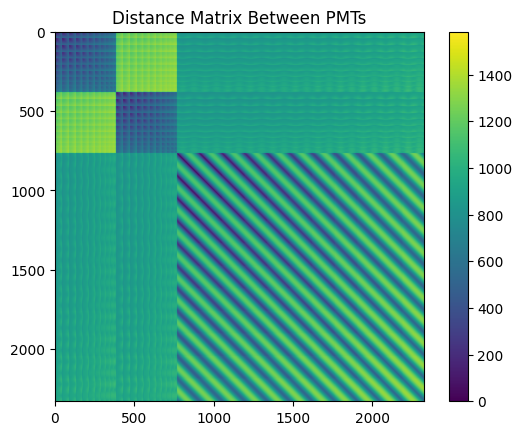

In [202]:
plt.imshow(dist)
plt.title('Distance Matrix Between PMTs')
plt.colorbar()
plt.show()

In [14]:
graph = np.zeros_like(dist)

In [15]:
edges = np.where(dist<300, 1, 0)

In [16]:
all_edges = np.argwhere(dist<300)

In [17]:
G = nx.Graph()
G.add_edges_from(all_edges)

In [18]:
G.number_of_edges() #avg of 57 edges per node 

134157

In [19]:
torch_graph = from_networkx(G)

In [20]:
torch_graph.pos = whatis

In [ ]:
pos_iter = np.broadcast_arrays(torch_graph.pos, x)[0]


In [188]:
torch.dtype

torch.dtype

In [189]:
proc_data = Data(x=torch.tensor(x), edge_index=torch_graph.edge_index,
        y=torch.tensor(y, dtype=torch.int32), pos=torch_graph.pos)

In [180]:
final_out = 16
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin = Sequential(Linear(final_out*2330, 16),
                              ReLU(),
                              Linear(16, 1), 
#                               ReLU(),
#                               Linear(16, 1), 
                              Sigmoid()
                             )
#         self.lin = Sequential()
#         self.lin.add(Input(final_out*2330))
#         self.lin.add(Dense(#final_out*2330, 
#                                           16, activation='relu'))
#         self.lin.add(Dense(1, activation='sigmoid'))
# #             Linear(final_out*2330, 16),)
# #                               ReLU(),
# #                               Linear(16, 1)]
# #                              )
        self.conv1 = GCNConv(4, 16)
        self.conv2 = GCNConv(16, final_out)
#         self.pool1 = ASAPooling(28)
#         self.conv3 = GCNConv(512, 256)
#         self.conv4 = GCNConv(256, 64)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
#         x = self.conv3(x, edge_index)
#         x = F.relu(x)
#         x = self.conv4(x, edge_index)
#         x = F.relu(x)
#         x = x.view(-1, 28*127)
#         x, edge_index, edge_weight, batch, perm = self.pool1(x, edge_index)
#         print(x)
#         x = F.relu(x)
#         print(x.shape)
        x = x.view(-1, final_out*2330)
        return self.lin(x)

In [181]:
model = Net()

In [190]:
class GCNSeq(tf.keras.utils.Sequence):
    def __init__(self, filename, batch_size=32, shuffle=False):
        data = pickle.load(open("./data/%s.pkl"%(filename), 'rb'))
        self.x, self.y = data['x'], data['y']
        self.x.newcharge = self.x.pmtcharge
        self.x.newcharge = ak.where(self.x.hittime<950, self.x.pmtcharge, 0)
        self.x.newcharge = ak.where(self.x.hittime>750, self.x.newcharge, 0)
        self.batch_size = batch_size
        self.pmt_pos = np.expand_dims(torch_graph.pos, axis=0)
        self.pmtpos_iter = np.repeat(self.pmt_pos, self.batch_size, axis=0)

        self.n_samples = len(self.y)
#         self.max_length=max_length
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return np.int(np.ceil(len(self.y) / self.batch_size))

    def __getitem__(self, idx):      
        i0 = idx * self.batch_size
        i1 = (idx + 1) * self.batch_size     
        
        indexes = self.indexes[i0:i1]        
        batch_y = self.y[indexes]

        dat = self.x[indexes]
        charge = np.zeros((self.batch_size, 2330))
       
        for i in range(self.batch_size):
            charge[i, dat.channel[i]]= charge[i, dat.channel[i]] + dat.pmtcharge[i]
        charge = np.reshape( charge, (len( charge ), 2330,1) )
        x = np.concatenate( (charge, self.pmtpos_iter), axis=-1).astype(np.float32)
        proc_data = Data(x=torch.tensor(x), edge_index=torch_graph.edge_index,
                                y=torch.tensor(batch_y, dtype=torch.int32), pos=torch_graph.pos)            
        return proc_data # x, np.asarray(batch_y)
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.y))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [161]:
w = GCNSeq('pn_train')

In [196]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [197]:
inputs = datagen.__getitem__(0)

In [198]:
inputs.y

tensor([1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 1, 0], dtype=torch.int32)

In [199]:
datagen = GCNSeq('pn_train')
for epoch in range(2):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i in range(0,10): #loop over batches 
        # get the inputs; data is a list of [inputs, labels]
        inputs = datagen.__getitem__(i)
        labels = inputs.y
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

RuntimeError: expected scalar type Long but found Int

In [43]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train.max_length, 0): #loop over batches 
        # get the inputs; data is a list of [inputs, labels]
        
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


NameError: name 'optimizer' is not defined

In [41]:
GCNConv()

torch_geometric.nn.conv.gcn_conv.GCNConv

In [39]:
def gnn_model_summary(model):
    
    model_params_list = list(model.named_parameters())
    print("----------------------------------------------------------------")
    line_new = "{:>20}  {:>25} {:>15}".format("Layer.Parameter", "Param Tensor Shape", "Param #")
    print(line_new)
    print("----------------------------------------------------------------")
    for elem in model_params_list:
        p_name = elem[0] 
        p_shape = list(elem[1].size())
        p_count = torch.tensor(elem[1].size()).prod().item()
        line_new = "{:>20}  {:>25} {:>15}".format(p_name, str(p_shape), str(p_count))
        print(line_new)
    print("----------------------------------------------------------------")
    total_params = sum([param.nelement() for param in model.parameters()])
    print("Total params:", total_params)
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable params:", num_trainable_params)
    print("Non-trainable params:", total_params - num_trainable_params)
gnn_model_summary(model)

----------------------------------------------------------------
     Layer.Parameter         Param Tensor Shape         Param #
----------------------------------------------------------------
        lin.0.weight                [16, 37280]          596480
          lin.0.bias                       [16]              16
        lin.2.weight                    [1, 16]              16
          lin.2.bias                        [1]               1
----------------------------------------------------------------
Total params: 596513
Trainable params: 596513
Non-trainable params: 0


In [ ]:
model.

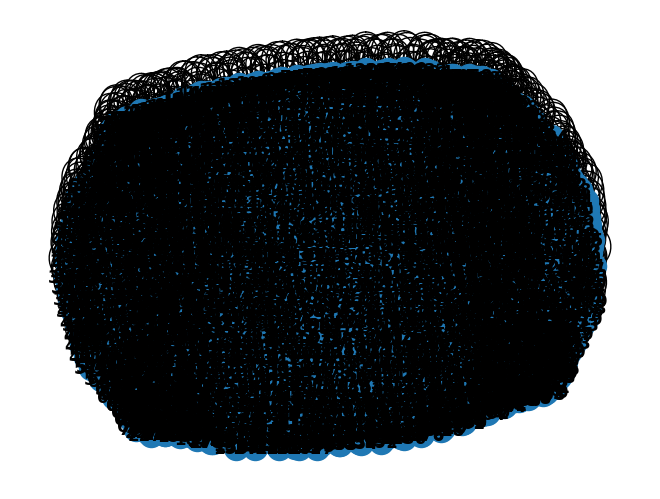

In [213]:
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

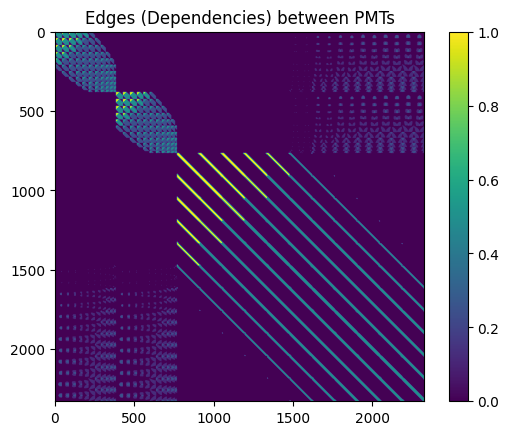

In [203]:
plt.imshow(edges)
plt.title('Edges (Dependencies) between PMTs')
plt.colorbar()
plt.show()

We want where quicknext<500 us (so another prompt follows) and the subid==1. 

What if we boost our fast-neutron stamps by not requiring it to be the first event (so tri-neutron events recorded too but in pairs?) 
<br>
Obviously this is not realistic since we'd veto these by having 3, but we can at least pretend they're di-neutrons! 

Edit: the next code is already doing that! We gain 1149/5500 of the stats from that trick, which is necessary. 

In [3]:
model = load_model('weights/embedder.h5')
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 16)      37280       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 16)      37280       input_2[0][0]                    
_______________________________________________________________________________________

### Prep data for model input

In [4]:
val = cnn_batched_data.EmbeddingSeq('test_water', batch_size=64, shuffle=False)
train = cnn_batched_data.EmbeddingSeq('train_water', batch_size=64, shuffle=False)

In [ ]:
rnn_out_test = model.predict(val, verbose=1)

In [ ]:
rnn_out_train = model.predict(train, verbose=1)

------

## Getting data in input form

Need to get those with a 1 for sure as it has a 0, then take those separated by the 0 or 1 

In [5]:
def get_scores(load_saved=False, save_these=False):
    if load_saved:
        rnn_out_test = np.loadtxt("testpreds.csv", delimiter=",", ndmin=2)
        rnn_out_train = np.loadtxt("trainpreds.csv", delimiter=",", ndmin=2)
    else: 
        rnn_out_test = model.predict(val, verbose=1)
        rnn_out_train = model.predict(train, verbose=1)
    if save_these:
        np.savetxt("testpreds.csv", rnn_out_test, delimiter=",")
        np.savetxt("trainpreds.csv", rnn_out_train, delimiter=",")
    
    return rnn_out_train, rnn_out_test

In [6]:
# rnn_out_train, rnn_out_test = get_scores(load_saved=False, save_these=True)
rnn_out_train, rnn_out_test = get_scores(load_saved=False, save_these=True)

194/194 [==============================] - 19s 97ms/step


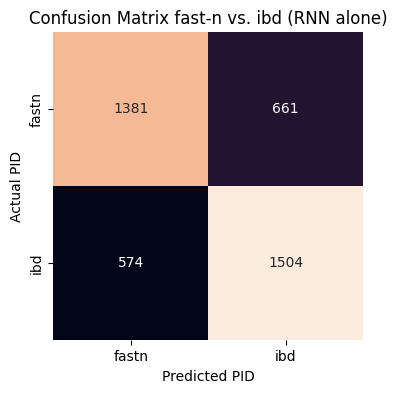

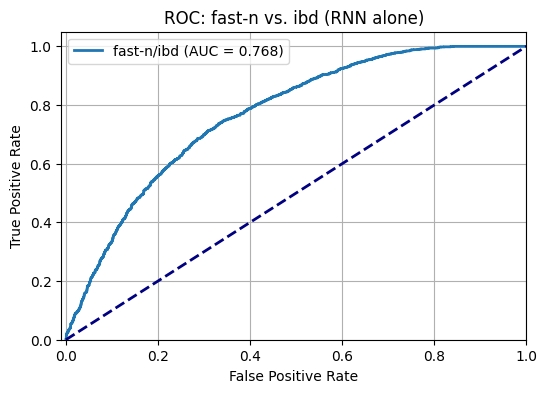

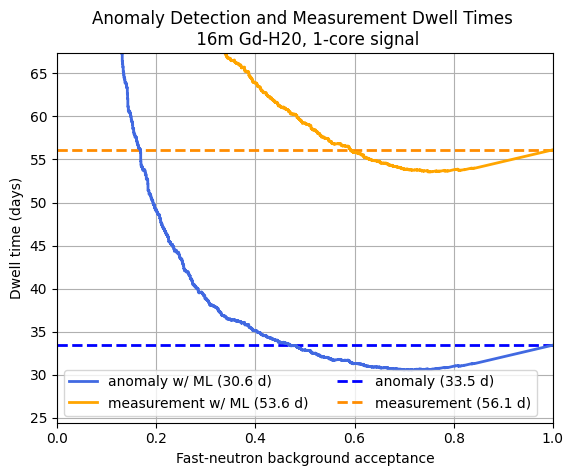

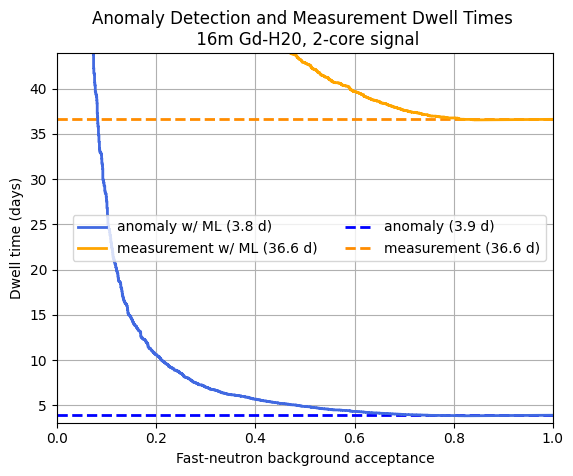

In [7]:
ml = ML_Evaluation(val.y, rnn_out_test)
ml.draw_confmat(extra_title='(RNN alone)')
tpr, fpr, thresholds = ml.draw_roc(extra_title='(RNN alone)')

acceptances = dict(fpr=fpr, tpr=tpr)
quick_analysis(acceptances)

## Take RNN output and add to X1 (RF) data

In [8]:
def rnn_to_rf(X_train, X_test, 
              y_train, y_test, 
              add_rnn=True, classes=2,
             ):
    dims_add = dimensions.copy()
    newdims = ['rnn_out']

    if classes>2:
        y_train = np.argmax(y_train, axis=1)
        y_test = np.argmax(y_test, axis=1)
        newdims = ['rnn_out_fn', 'rnn_out_ibd0', 'rnn_out_ibd1']
    if not add_rnn: 
        return X_train, X_test, y_train, y_test, dims_add
    
    new_train = np.hstack((X_train, rnn_out_train))
    new_test = np.hstack((X_test, rnn_out_test))
    
    for i in newdims:
        dims_add.append(i)    
    return new_train, new_test, y_train, y_test, dims_add

In [9]:
dimensions = [
    'n9', 'n100', 
#     'x', 'y', 'z', # 'r',
    'id_plus_dr_hit', 
    'good_dir', 
#     'good_dir_next', # 'good_pos_next', 
#     'good_pos',
    'closestPMT', 'closestPMT_next', # 'distpmt', 
    'drNextr', # 'dzNextz', 
     'dt_next_us', 
#     'azimuth_ks',#  'azimuth_ks_next',
#     'n100_next','n9_next',
    'pe', 
    'beta_one', # 'beta_four',
#     'beta_one', 'beta_two', 'beta_three', 'beta_four', 'beta_five', 'beta_six',
#     'beta_one_prev', 'beta_two_prev', 'beta_three_prev', 'beta_four_prev', 'beta_five_prev', 'beta_six_prev',
]

In [10]:
X1 = get_dims(train.x1, dimensions=dimensions)
X1 = ak.to_pandas(X1)

X1val = get_dims(val.x1, dimensions=dimensions)
X1val = ak.to_pandas(X1val)

sc = StandardScaler()
X_train3, y_train = sc.fit_transform(X1), train.y
X_test3, y_test = sc.transform(X1val), val.y

Remaining variables selected for analysis: 10
Remaining variables selected for analysis: 10


In [11]:
new_train, new_test, yy_train, yy_test, dims_add = rnn_to_rf(X_train3, X_test3, y_train, y_test, 
                                                            add_rnn=True,)

In [12]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(
    n_estimators=100, 
    max_depth=12, 
#     min_samples_leaf=2,
    bootstrap=True,
)
#Train the model using the training sets
clf.fit(new_train,yy_train)
feature_imp = pd.Series(clf.feature_importances_,index=dims_add).sort_values(ascending=False)

In [13]:
y_train_pred = clf.predict(new_train)
y_test_pred=clf.predict(new_test)
scores = clf.predict_proba(new_test)

In [14]:
# Model Accuracy, how often is the classifier correct?
print("Train Accuracy: %.2f%%"%(metrics.accuracy_score(yy_train, y_train_pred)*100))
print("Test Accuracy: %.2f%%"%(metrics.accuracy_score(yy_test, y_test_pred)*100))

Train Accuracy: 96.93%
Test Accuracy: 87.99%


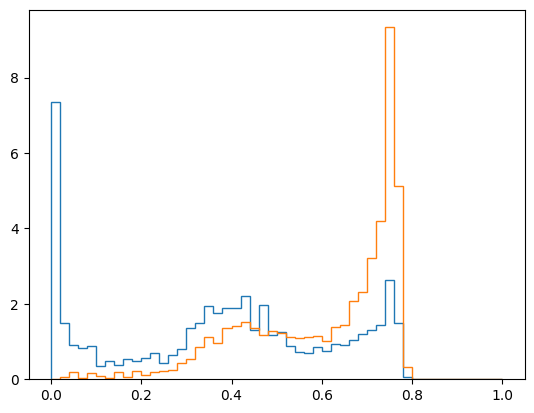

In [15]:
kw = dict(histtype='step', bins=50, range=[0,1], density=True)
plt.hist(rnn_out_test[y_test==0], **kw)
plt.hist(rnn_out_test[y_test==1], **kw)
# plt.yscale('log')
plt.show()

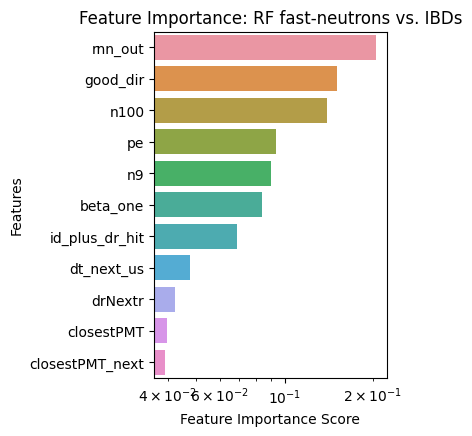

In [16]:
# Creating a bar plot
plt.figure(figsize=(3, 4.5))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.xscale('log')
plt.ylabel('Features')
plt.title("Feature Importance: RF fast-neutrons vs. IBDs")
plt.show()

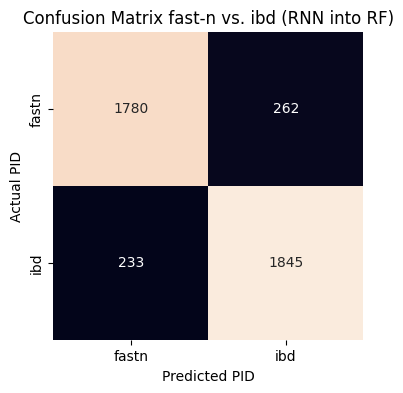

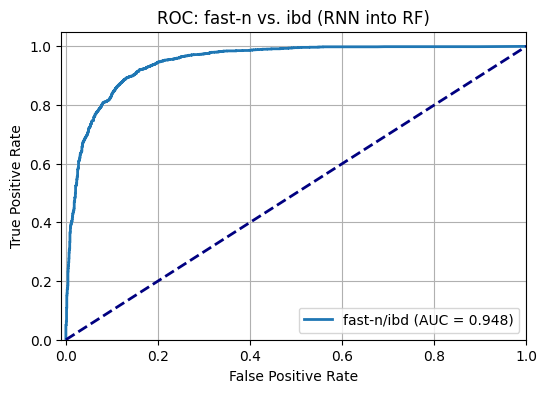

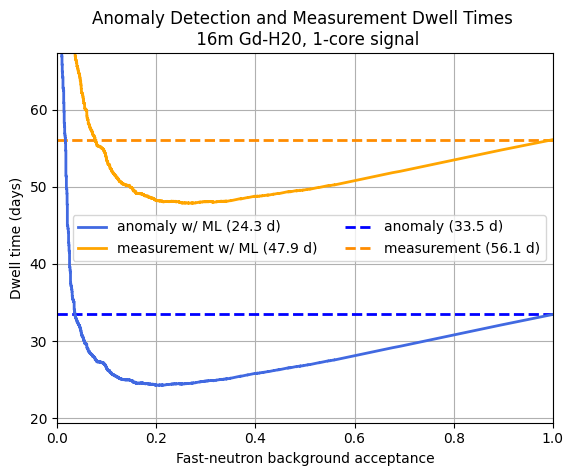

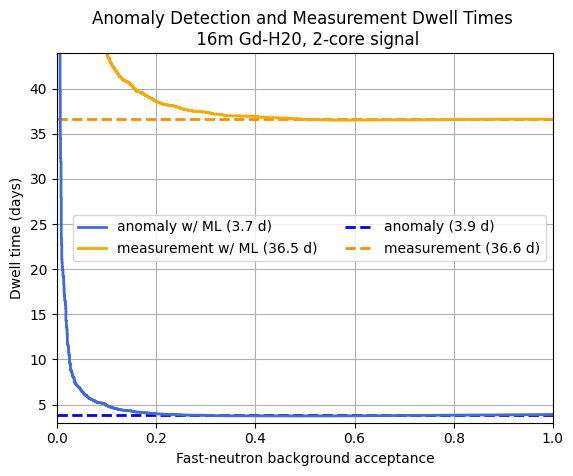

In [17]:
ml = ML_Evaluation(y_test, scores)
ml.draw_confmat(extra_title='(RNN into RF)')
tpr, fpr, thresholds = ml.draw_roc(extra_title='(RNN into RF)')

acceptances = dict(fpr=fpr, tpr=tpr)
# save_obj(acceptances, 'rates')
quick_analysis(acceptances)

## Trying more rigorous AdaBoost

In [66]:
clf=RandomForestClassifier(n_estimators=100, 
    max_depth=5, 
    bootstrap=True,
)
bdt = AdaBoostClassifier(base_estimator=clf, n_estimators=20, random_state=43)

In [67]:
%%time
bdt.fit(new_train,yy_train)

CPU times: user 26.1 s, sys: 22.6 ms, total: 26.1 s
Wall time: 26.1 s


AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=5),
                   n_estimators=20, random_state=43)

In [68]:
scores = bdt.predict(new_test)

In [69]:
print(bdt.score(new_train, y_train))
print(bdt.score(new_test, y_test))

0.9289529050008092
0.8973300970873787


## Stacking

In [70]:
from sklearn.ensemble import StackingClassifier

In [131]:
def simple_model():
    nn = Sequential()
    nn.add(Input(shape=(new_train.shape[1],)))
#     nn.add(Dense(64, activation='relu'))
    nn.add(Dense(32, activation='relu'))
    nn.add(Dense(16, activation='relu'))
    nn.add(Dense(1, activation='sigmoid'))

    nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'],)
    
    return nn
# nn.summary()

In [132]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [133]:
from sklearn import pipeline

In [121]:
nnn = pipeline.Pipeline([('nn', nn_estimator)])

In [134]:
nn_estimator = KerasClassifier(build_fn= simple_model, epochs=10, batch_size=32, verbose=1)

In [135]:
nn_estimator._estimator_type='classifier'

In [136]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=8, random_state=43)),
    ('nn', nn_estimator), 
             ]

In [137]:
clf = StackingClassifier(estimators=estimators, 
#                          final_estimator=LogisticRegression()
                        )

In [138]:
%%time
clf = clf.fit(new_train, y_train)

Epoch 1/10
387/387 [==============================] - 0s 1ms/step - loss: 0.4081 - accuracy: 0.8262
Epoch 2/10
387/387 [==============================] - 0s 1ms/step - loss: 0.2962 - accuracy: 0.8759
Epoch 3/10
387/387 [==============================] - 0s 993us/step - loss: 0.2873 - accuracy: 0.8809
Epoch 4/10
387/387 [==============================] - 0s 1ms/step - loss: 0.2823 - accuracy: 0.8816
Epoch 5/10
387/387 [==============================] - 0s 1ms/step - loss: 0.2794 - accuracy: 0.8815
Epoch 6/10
387/387 [==============================] - 0s 1ms/step - loss: 0.2762 - accuracy: 0.8846
Epoch 7/10
387/387 [==============================] - 0s 1ms/step - loss: 0.2745 - accuracy: 0.8847
Epoch 8/10
387/387 [==============================] - 0s 1ms/step - loss: 0.2745 - accuracy: 0.8843
Epoch 9/10
387/387 [==============================] - 0s 1ms/step - loss: 0.2728 - accuracy: 0.8874
Epoch 10/10
387/387 [==============================] - 0s 1ms/step - loss: 0.2713 - accuracy: 0.88

In [139]:
print(clf.score(new_train, y_train))
print(clf.score(new_test, y_test))

387/387 [==============================] - 0s 483us/step
0.8996601391810972
129/129 [==============================] - 0s 447us/step
0.8919902912621359


In [140]:
scores = clf.predict_proba(new_test)

129/129 [==============================] - 0s 531us/step


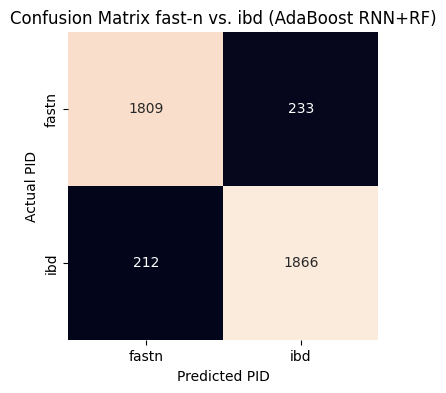

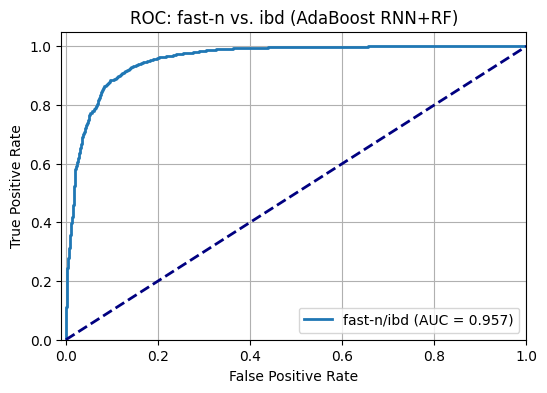

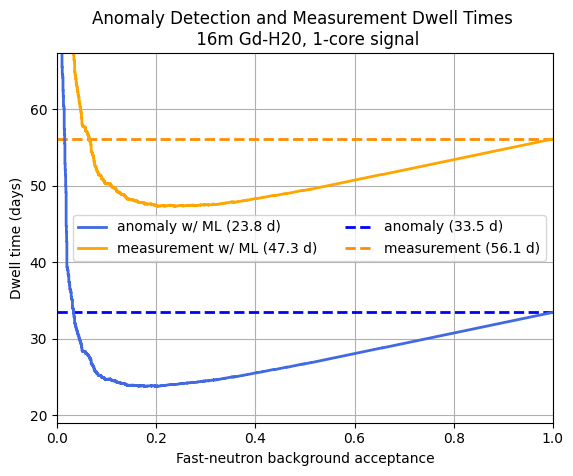

In [ ]:
ml = ML_Evaluation(y_test, scores)
ml.draw_confmat(extra_title='(AdaBoost RNN+RF)')
tpr, fpr, thresholds = ml.draw_roc(extra_title='(AdaBoost RNN+RF)')

acceptances = dict(fpr=fpr, tpr=tpr)
# save_obj(acceptances, 'rates')
quick_analysis(acceptances)

## AdaBoost (but the wrong way)

In [35]:
rfpred = clf.predict_proba(new_train)[:,1]
rnnpred = rnn_out_train[:,0]
X = np.vstack([rfpred, rnnpred]).T

bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME.R",
                         n_estimators=100)
bdt.fit(X, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=100)

In [36]:
rfpredtest = clf.predict_proba(new_test)[:,1].reshape(len(new_test),1)
rnnpredtest = rnn_out_test
Xtest = np.hstack([rfpredtest, rnnpredtest])
scores = bdt.predict_proba(Xtest)

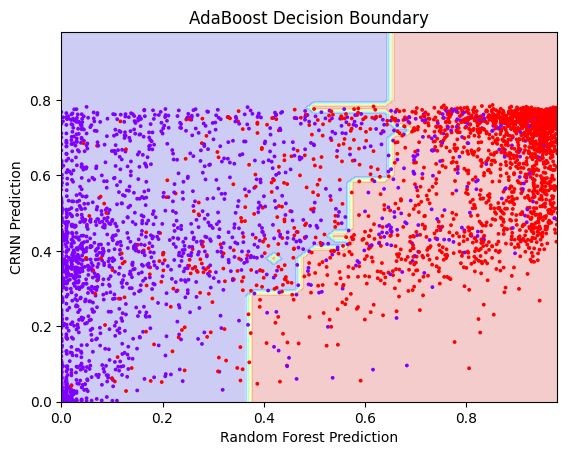

In [37]:
x_min, x_max = 0, 1
y_min, y_max = 0, 1
plot_step = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, 
                  cmap=plt.cm.jet, alpha=0.2
                 )
plt.axis("tight")
plt.xlabel('Random Forest Prediction')
plt.ylabel('CRNN Prediction')
plt.title('AdaBoost Decision Boundary')
plt.scatter(rfpredtest, rnnpredtest, c=y_test, cmap=plt.cm.rainbow, s=3)
plt.show()

In [38]:
print(bdt.score(X, y_train))
print(bdt.score(Xtest, y_test))

0.9764525004045962
0.8764563106796116


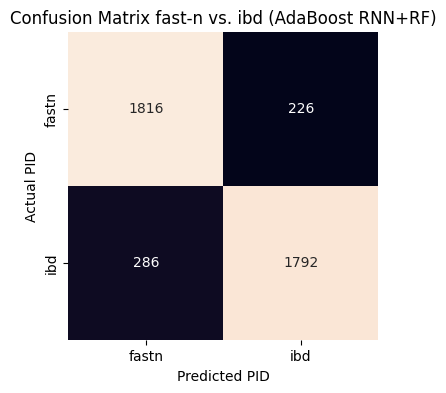

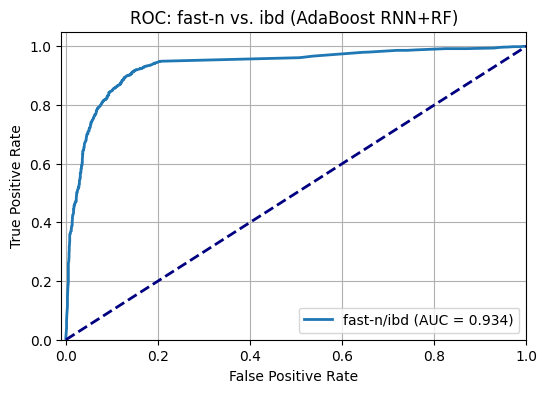

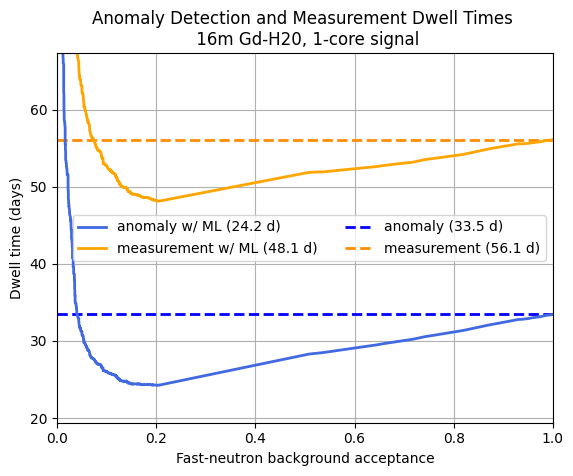

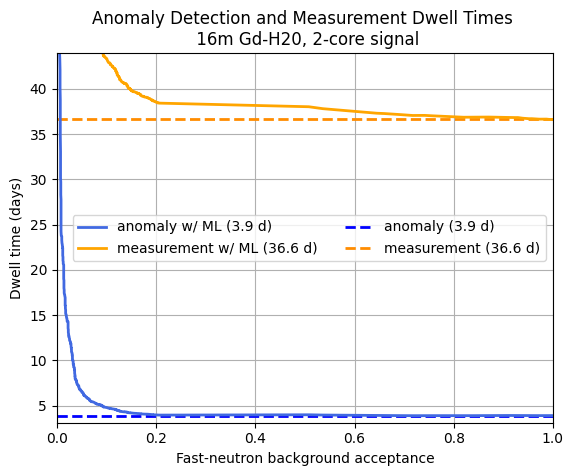

In [22]:
ml = ML_Evaluation(y_test, scores)
ml.draw_confmat(extra_title='(AdaBoost RNN+RF)')
tpr, fpr, thresholds = ml.draw_roc(extra_title='(AdaBoost RNN+RF)')

acceptances = dict(fpr=fpr, tpr=tpr)
# save_obj(acceptances, 'rates')
quick_analysis(acceptances)

### Simply taking the average as a comparison

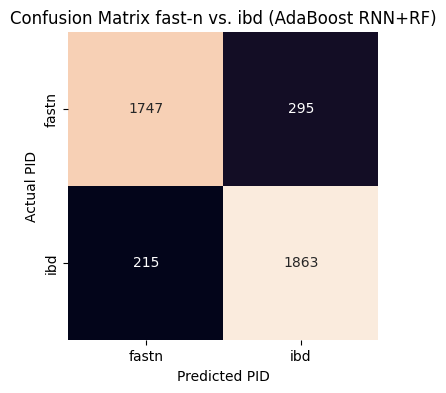

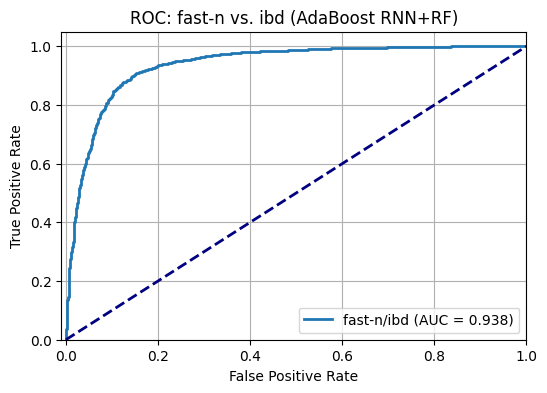

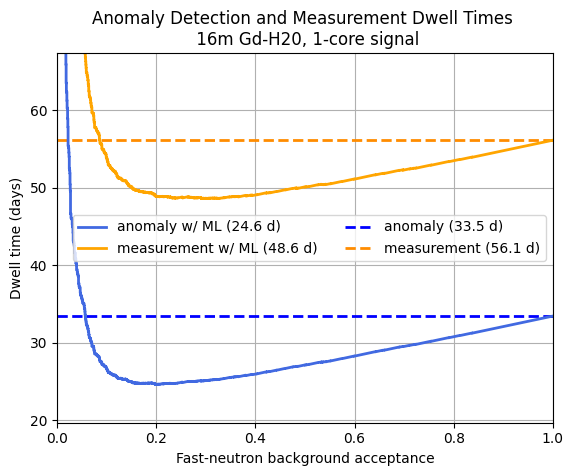

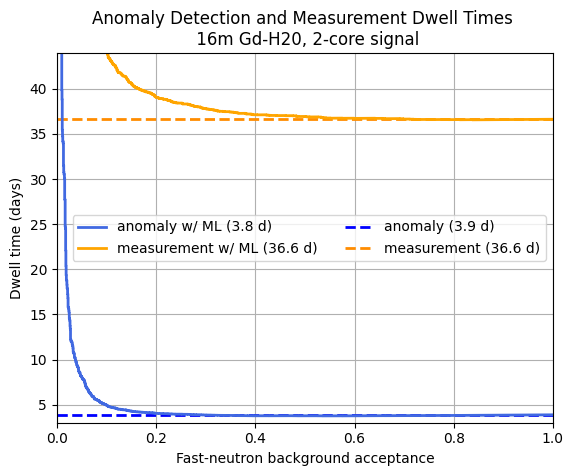

In [27]:
avgpred = (rfpredtest + rnnpredtest)/2
avgpred = avgpred.reshape(len(avgpred),1)
ml = ML_Evaluation(y_test, avgpred)
ml.draw_confmat(extra_title='(AdaBoost RNN+RF)')
tpr, fpr, thresholds = ml.draw_roc(extra_title='(AdaBoost RNN+RF)')

acceptances = dict(fpr=fpr, tpr=tpr)
# save_obj(acceptances, 'rates')
quick_analysis(acceptances)